In [1]:
pip install torchbnn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from sklearn import datasets
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from datetime import datetime 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import  mean_absolute_percentage_error, mean_absolute_error,mean_squared_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/VCB-Historical-Data.csv',index_col=0,parse_dates=True).sort_values(by='Date',ascending=True)

df['Price']=df['Price'].replace(',','',regex=True).astype(float)

df = df.rename(columns={'Price': 'Close'})
df.head()



,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,41161.0,"41,391","41,698","41,084",1.38M,0.19%
2019-01-03,41161.0,"41,468","41,545","40,470",1.37M,0.00%
2019-01-04,41775.0,"40,931","41,775","40,393",1.67M,1.49%
2019-01-07,41929.0,"42,466","42,620","41,852",1.50M,0.37%
2019-01-08,42236.0,"42,236","42,390","41,852",1.68M,0.73%


In [4]:
df1 = df[['Close']]
df1

,Close
Date,
2019-01-02,41161.0
2019-01-03,41161.0
2019-01-04,41775.0
2019-01-07,41929.0
2019-01-08,42236.0
...,...
2023-05-26,92000.0
2023-05-29,93100.0
2023-05-30,94500.0


In [5]:
# 3. Scaler data
scaler=MinMaxScaler()
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
mean_close=df1.mean()
std_close=df1.std()

In [7]:
# 4. Chia train test tỉ lệ 6-3-1
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [8]:
# 5. Hàm Create Dataset
#window sliding
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
x = torch.from_numpy(X_train)
y = torch.from_numpy(y_train)
x = torch.tensor(x).to(torch.float)
y=  torch.tensor(y).to(torch.float)




<ipython-input-10-b1de043f30de>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(torch.float)
<ipython-input-10-b1de043f30de>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=  torch.tensor(y).to(torch.float)


In [11]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=mean_close, prior_sigma= std_close, in_features=40, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=mean_close, prior_sigma= std_close, in_features=100, out_features=1),
)

In [12]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
kl_weight = 0.1
for step in range(3000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([619])) that is different to the input size (torch.Size([619, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


- MSE : 0.05, KL : 3.96


In [14]:
X_test = torch.from_numpy(X_test)
ytest = torch.from_numpy(ytest)

X_test = torch.tensor(X_test).to(torch.float)
ytest=  torch.tensor(ytest).to(torch.float)

y_pred=model(X_test)




<ipython-input-14-e05097e078a4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).to(torch.float)
<ipython-input-14-e05097e078a4>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytest=  torch.tensor(ytest).to(torch.float)


In [15]:
X_val = torch.from_numpy(X_val)
yval = torch.from_numpy(yval)
X_val = torch.tensor(X_val).to(torch.float)
yval=  torch.tensor(yval).to(torch.float)

y_pred_val=model(X_val)

<ipython-input-15-e1d347aee92c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val).to(torch.float)
<ipython-input-15-e1d347aee92c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yval=  torch.tensor(yval).to(torch.float)


In [16]:

y_pred = y_pred.detach().numpy()
y_pred_val=y_pred_val.detach().numpy()
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

original_ytest = scaler.inverse_transform(ytest.reshape(-1,1)) 
original_yval = scaler.inverse_transform(yval.reshape(-1,1)) 

In [17]:
yval = yval.detach().numpy()
ytest=ytest.detach().numpy()

In [18]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE

valid_rmse = np.sqrt(np.mean((y_pred_val - original_yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - original_ytest)**2))
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

Validation RMSE: 50565.81
Testing RMSE: 12888.61


In [19]:
# 13. Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = mean_absolute_error(original_yval, y_pred_val)
test_mae = mean_absolute_error(original_ytest , y_pred)
print(f"Validation MAE: {valid_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

Validation MAE: 50521.33
Testing MAE: 11724.12


In [20]:
# 14. Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = mean_absolute_percentage_error(original_yval, y_pred_val)
test_mape = mean_absolute_percentage_error(original_ytest ,y_pred)
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")

Validation MAPE: 55.40%
Testing MAPE: 14.57%


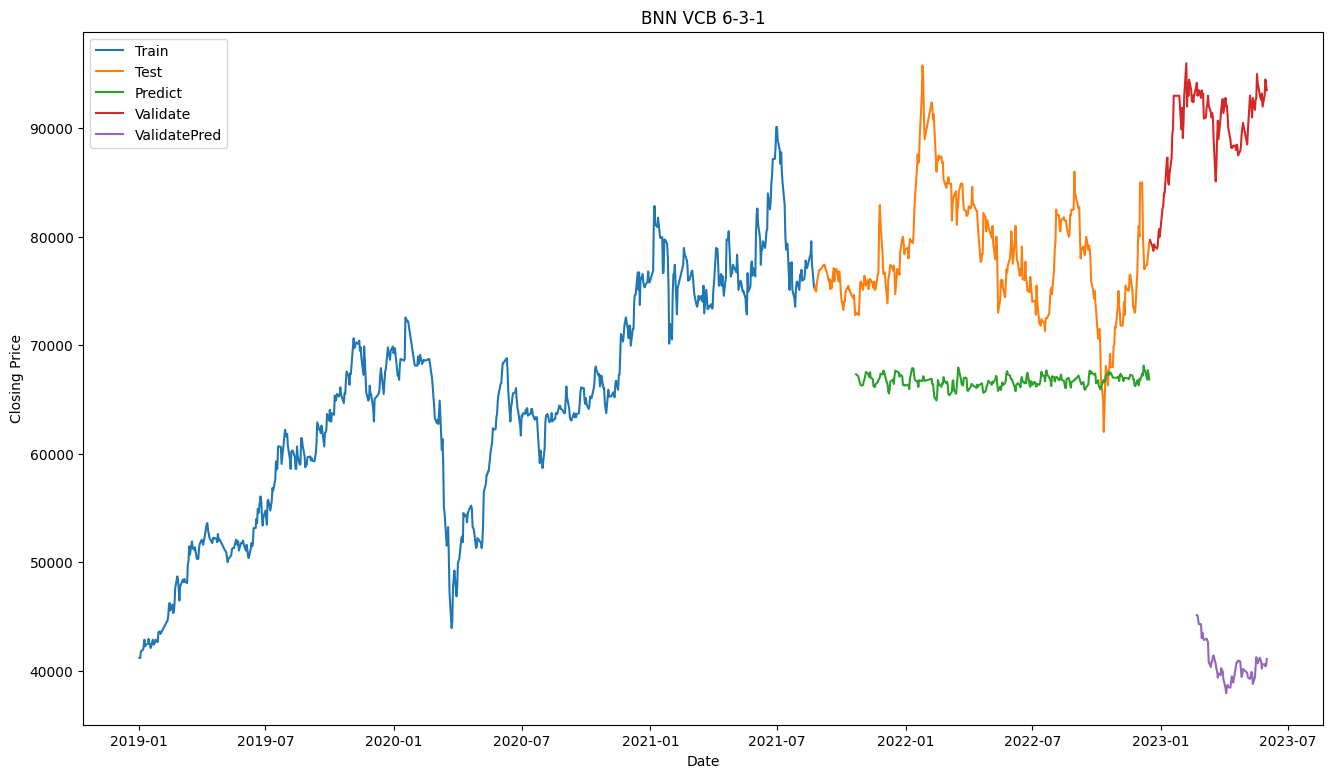

In [21]:

# 9.Vẽ hình
plt.figure(figsize=(16,9))
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('BNN VCB 6-3-1')
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()